In [ ]:
# Load ActivityNet v1.3 action segments
ann = json.loads(ANN_PATH.read_text())
db = ann["database"]
print("Annotated videos in JSON:", len(db))

# In JSON, keys are bare YouTube IDs: "c_NlYvL96y0"
# In files, names are: "v_c_NlYvL96y0.mp4"

def youtube_id_from_filename(p: Path) -> str:
    stem = p.stem
    return stem[2:] if stem.startswith("v_") else stem


# Find a few videos that exist both on disk and in the annotations
annotated_on_disk = []
for p in random.sample(mp4_paths, k=min(200, len(mp4_paths))):
    yid = youtube_id_from_filename(p)
    if yid in db:
        annotated_on_disk.append(p)
    if len(annotated_on_disk) >= 5:
        break

print("Annotated videos found on disk (from a small sample):", len(annotated_on_disk))


for p in annotated_on_disk:
    yid = youtube_id_from_filename(p)
    anns = db[yid].get("annotations", [])
    info = video_info(p)
    
    print(f"\n{p.name}")
    print(f"  YouTube ID: {yid}")
    print(f"  Decoded duration: {info['duration_sec']:.2f}s")
    print(f"  Annotation duration: {db[yid].get('duration')}s")
    print(f"  Number of segments: {len(anns)}")
    
    for i, a in enumerate(anns[:3]):
        seg = a["segment"]
        label = a["label"]
        seg_len = seg[1] - seg[0]
        pct_of_video = (seg_len / info['duration_sec'] * 100) if info['duration_sec'] else 0
        
        print(f"  Segment {i+1}: [{seg[0]:.1f}s - {seg[1]:.1f}s] = {seg_len:.1f}s ({pct_of_video:.1f}%)")
        print(f"    Label: {label}")



Annotated videos in JSON: 19994
Annotated videos found on disk (from a small sample): 5

DIAGNOSTIC: Checking segment timestamps vs video duration

v_yVJGQI5MBIk.mp4
  YouTube ID: yVJGQI5MBIk
  Decoded duration: 95.60s
  Annotation duration: 95.481s
  Number of segments: 1
  Segment 1: [0.2s - 95.3s] = 95.1s (99.5% of video)
    Label: Capoeira

v_nDGhaYCgRiI.mp4
  YouTube ID: nDGhaYCgRiI
  Decoded duration: 211.73s
  Annotation duration: 211.743s
  Number of segments: 2
  Segment 1: [43.0s - 114.7s] = 71.7s (33.9% of video)
    Label: Slacklining
  Segment 2: [117.6s - 190.6s] = 73.0s (34.5% of video)
    Label: Slacklining

v_Et8xkGzQOTA.mp4
  YouTube ID: Et8xkGzQOTA
  Decoded duration: 42.13s
  Annotation duration: 42.12s
  Number of segments: 1
  Segment 1: [11.6s - 35.2s] = 23.5s (55.8% of video)
    Label: Breakdancing

v_v1hQ0vf66QY.mp4
  YouTube ID: v1hQ0vf66QY
  Decoded duration: 212.07s
  Annotation duration: 212.045s
  Number of segments: 10
  Segment 1: [16.8s - 36.3s] = 19

v_yVJGQI5MBIk.mp4
segment: [0.19999999999999998, 95.32689342403629] label: Capoeira


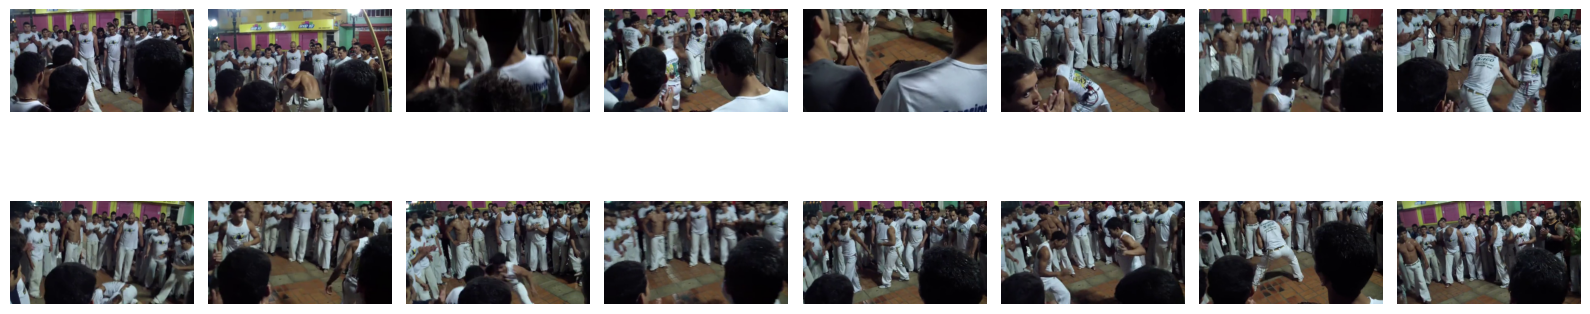

In [13]:
import matplotlib.pyplot as plt


def show_segment_frames(video_path: Path, start_sec: float, end_sec: float, num_frames: int = 16):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_f = int(max(0, start_sec * fps))
    end_f = int(min(nframes - 1, end_sec * fps))
    if end_f <= start_f:
        start_f, end_f = 0, max(0, nframes - 1)

    idxs = np.linspace(start_f, end_f, num_frames).astype(int)

    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, fr = cap.read()
        if not ok:
            continue
        fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
        frames.append(fr)

    cap.release()

    n = len(frames)
    cols = 8
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(16, 2.5 * rows))
    for i, fr in enumerate(frames):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(fr)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Visualize the first segment of the first annotated example (if available)
if annotated_on_disk:
    p = annotated_on_disk[0]
    yid = youtube_id_from_filename(p)
    a0 = db[yid]["annotations"][0]
    s, e = a0["segment"]
    lab = a0["label"]
    print(p.name)
    print("segment:", [s, e], "label:", lab)
    show_segment_frames(p, s, e)




Video: v_yVJGQI5MBIk.mp4
Action: Capoeira
Segment: [0.2s - 95.3s]

Full video:



Action segment frames [0.2s - 95.3s]:


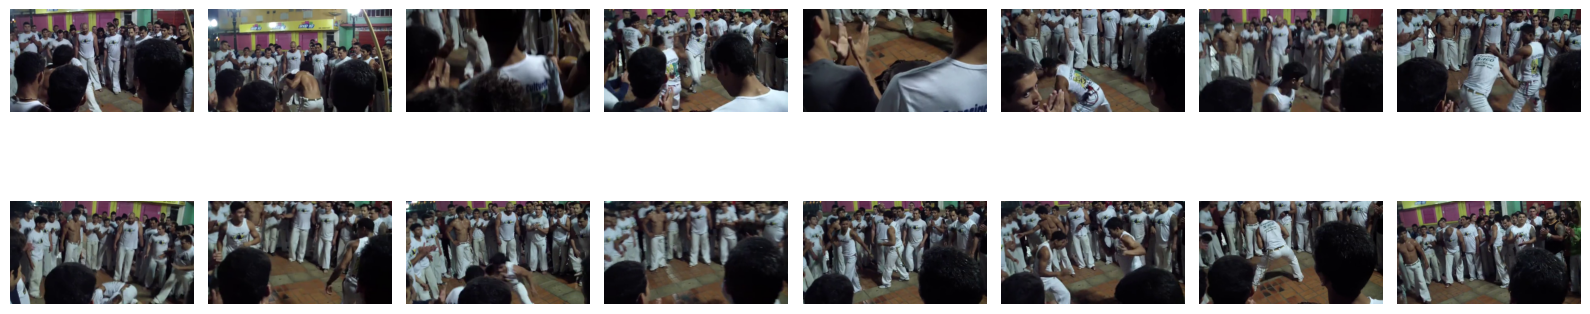


Video: v_nDGhaYCgRiI.mp4
Action: Slacklining
Segment: [43.0s - 114.7s]

Full video:



Action segment frames [43.0s - 114.7s]:


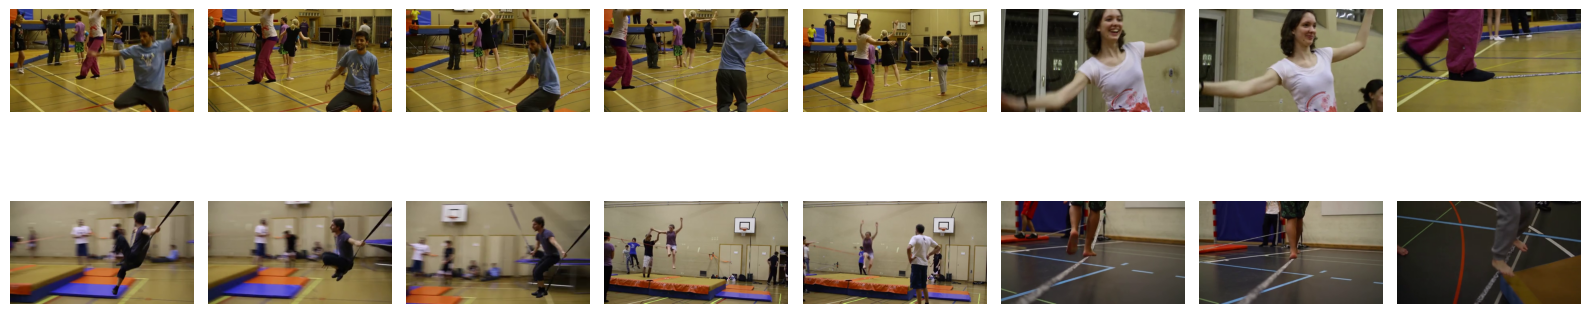


Video: v_Et8xkGzQOTA.mp4
Action: Breakdancing
Segment: [11.6s - 35.2s]

Full video:



Action segment frames [11.6s - 35.2s]:


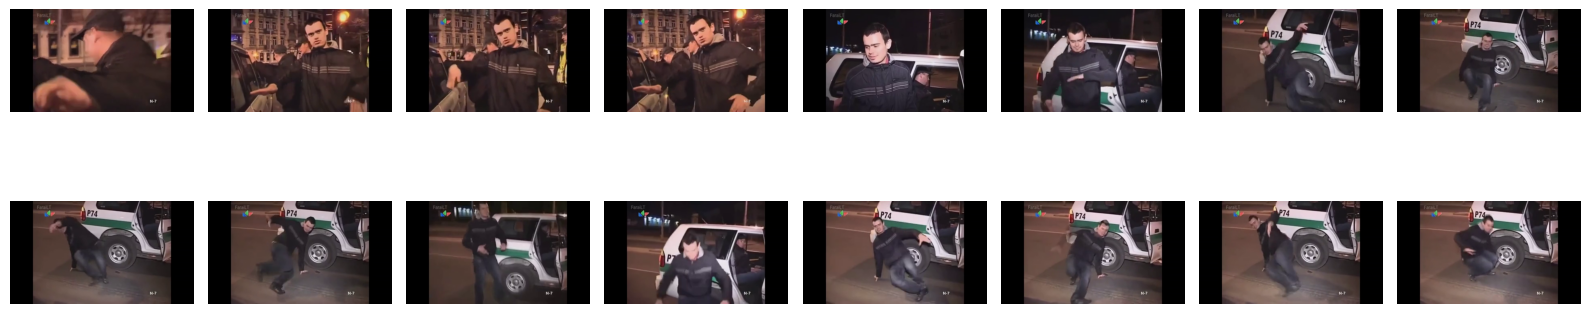

In [14]:
# Show a few annotated examples: full video + the specific action segment

for p in annotated_on_disk[:3]:
    yid = youtube_id_from_filename(p)
    anns = db[yid]["annotations"]
    
    print(f"\n{'='*60}")
    print(f"Video: {p.name}")
    print(f"Action: {anns[0]['label']}")
    print(f"Segment: [{anns[0]['segment'][0]:.1f}s - {anns[0]['segment'][1]:.1f}s]")
    print(f"{'='*60}")
    
    print("\nFull video:")
    display(Video(str(p), width=400))
    
    # Show the segment frames
    s, e = anns[0]["segment"]
    print(f"\nAction segment frames [{s:.1f}s - {e:.1f}s]:")
    show_segment_frames(p, s, e, num_frames=16)



## Generate embeddings

Now that we've seen the videos and segments, let's generate VideoMAEv2 embeddings for:
- the full video
- the labeled action segment



In [15]:
import torch
from transformers import AutoModel

MODEL_DIR = (REPO_ROOT / "model" / "VideoMAEv2-Base").resolve()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading VideoMAEv2...")
model = AutoModel.from_pretrained(str(MODEL_DIR), trust_remote_code=True)
model = model.to(device)
model.eval()
print(f"Loaded on {device}")



Loading VideoMAEv2...
Loaded on cuda


In [16]:
def load_video_frames(path: Path, start_sec=None, end_sec=None, num_frames: int = 16):
    cap = cv2.VideoCapture(str(path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if start_sec is None or end_sec is None:
        start_f, end_f = 0, max(0, nframes - 1)
    else:
        start_f = int(start_sec * fps)
        end_f = int(end_sec * fps)

    idxs = np.linspace(start_f, end_f, num_frames).astype(int)

    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, fr = cap.read()
        if ok:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            fr = cv2.resize(fr, (224, 224))
            fr = (fr / 255.0 - 0.5) / 0.5
            frames.append(fr)

    cap.release()
    return np.stack(frames)


def get_embedding(path: Path, start_sec=None, end_sec=None):
    frames = load_video_frames(path, start_sec, end_sec)
    x = torch.tensor(frames, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        emb = model.extract_features(x)
    
    return emb.cpu().numpy().squeeze()


# Generate embeddings for a few examples
print("Generating embeddings...\n")

for p in annotated_on_disk[:3]:
    yid = youtube_id_from_filename(p)
    s, e = db[yid]["annotations"][0]["segment"]
    
    full_emb = get_embedding(p)
    seg_emb = get_embedding(p, start_sec=s, end_sec=e)
    
    print(f"{p.name}")
    print(f"  Full video embedding: {full_emb.shape}")
    print(f"  Segment embedding: {seg_emb.shape}")



Generating embeddings...

v_yVJGQI5MBIk.mp4
  Full video embedding: (768,)
  Segment embedding: (768,)
v_nDGhaYCgRiI.mp4
  Full video embedding: (768,)
  Segment embedding: (768,)
v_Et8xkGzQOTA.mp4
  Full video embedding: (768,)
  Segment embedding: (768,)
